# **任务描述：**

### 本次实践是一个多分类任务，需要将照片中的宝石分别进行识别，完成**宝石的识别**

### **实践平台：百度AI实训平台-AI Studio、PaddlePaddle2.0.0 动态图**


![](https://ai-studio-static-online.cdn.bcebos.com/7640d4434f894f5dbae1d85c62e54b8476e24856aabc4c5f9915fea1b26f3ebc)


# 深度神经网络(DNN)

### **深度神经网络（Deep Neural Networks，简称DNN）是深度学习的基础，其结构为input、hidden（可有多层）、output，每层均为全连接。**
![](https://ai-studio-static-online.cdn.bcebos.com/c60fc28848cf469fa3a7824aa637a03f3b2b213ce7b84659919cb24b4430bffb)



# 数据集介绍

* **数据集文件名为archive_train.zip,archive_test.zip。**

* **该数据集包含25个类别不同宝石的图像。**

* **这些类别已经分为训练和测试数据。**

* **图像大小不一，格式为.jpeg。**


![](https://ai-studio-static-online.cdn.bcebos.com/7640d4434f894f5dbae1d85c62e54b8476e24856aabc4c5f9915fea1b26f3ebc)


In [ ]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

archive_test  data55032  dataset  readme.json


In [ ]:
#导入需要的包
import os
import zipfile
import random
import json
import cv2
import numpy as np
from PIL import Image
import paddle
import matplotlib.pyplot as plt
from paddle.io import Dataset

# 1、数据准备

In [ ]:
'''
参数配置
'''
train_parameters = {
    "input_size": [3, 224, 224],                           #输入图片的shape
    "class_dim": -1,                                     #分类数
    "src_path":"data/data55032/archive_train.zip",       #原始数据集路径
    "target_path":"/home/aistudio/data/dataset",        #要解压的路径 
    "train_list_path": "./train.txt",              #train_data.txt路径
    "eval_list_path": "./eval.txt",                  #eval_data.txt路径
    "label_dict":{},                                    #标签字典
    "readme_path": "/home/aistudio/data/readme.json",   #readme.json路径
    "num_epochs": 20,                                    #训练轮数
    "train_batch_size": 32,                             #批次的大小
    "learning_strategy": {                              #优化函数相关的配置
        "lr": 0.001                                     #超参数学习率
    } 
}



In [ ]:
def unzip_data(src_path,target_path):

    '''
    解压原始数据集，将src_path路径下的zip包解压至data/dataset目录下
    '''

    if(not os.path.isdir(target_path)):    
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()
    else:
        print("文件已解压")


In [ ]:
def get_data_list(target_path,train_list_path,eval_list_path):
    '''
    生成数据列表
    '''
    #存放所有类别的信息
    class_detail = []
    #获取所有类别保存的文件夹名称
    data_list_path=target_path
    class_dirs = os.listdir(data_list_path)
    if '__MACOSX' in class_dirs:
        class_dirs.remove('__MACOSX')
    # #总的图像数量
    all_class_images = 0
    # #存放类别标签
    class_label=0
    # #存放类别数目
    class_dim = 0
    # #存储要写进eval.txt和train.txt中的内容
    trainer_list=[]
    eval_list=[]
    #读取每个类别
    for class_dir in class_dirs:
        if class_dir != ".DS_Store":
            class_dim += 1
            #每个类别的信息
            class_detail_list = {}
            eval_sum = 0
            trainer_sum = 0
            #统计每个类别有多少张图片
            class_sum = 0
            #获取类别路径 
            path = os.path.join(data_list_path,class_dir)
            # 获取所有图片
            img_paths = os.listdir(path)
            for img_path in img_paths:                                  # 遍历文件夹下的每个图片
                if img_path =='.DS_Store':
                    continue
                name_path = os.path.join(path,img_path)                       # 每张图片的路径
                if class_sum % 15 == 0:                                 # 每10张图片取一个做验证数据
                    eval_sum += 1                                       # eval_sum为测试数据的数目
                    eval_list.append(name_path + "\t%d" % class_label + "\n")
                else:
                    trainer_sum += 1 
                    trainer_list.append(name_path + "\t%d" % class_label + "\n")#trainer_sum测试数据的数目
                class_sum += 1                                          #每类图片的数目
                all_class_images += 1                                   #所有类图片的数目
            
            # 说明的json文件的class_detail数据
            class_detail_list['class_name'] = class_dir             #类别名称
            class_detail_list['class_label'] = class_label          #类别标签
            class_detail_list['class_eval_images'] = eval_sum       #该类数据的测试集数目
            class_detail_list['class_trainer_images'] = trainer_sum #该类数据的训练集数目
            class_detail.append(class_detail_list)  
            #初始化标签列表
            train_parameters['label_dict'][str(class_label)] = class_dir
            class_label += 1
            
    #初始化分类数
    train_parameters['class_dim'] = class_dim
    print(train_parameters)
    #乱序  
    random.shuffle(eval_list)
    with open(eval_list_path, 'a') as f:
        for eval_image in eval_list:
            f.write(eval_image) 
    #乱序        
    random.shuffle(trainer_list) 
    with open(train_list_path, 'a') as f2:
        for train_image in trainer_list:
            f2.write(train_image) 

    # 说明的json文件信息
    readjson = {}
    readjson['all_class_name'] = data_list_path                  #文件父目录
    readjson['all_class_images'] = all_class_images
    readjson['class_detail'] = class_detail
    jsons = json.dumps(readjson, sort_keys=True, indent=4, separators=(',', ': '))
    with open(train_parameters['readme_path'],'w') as f:
        f.write(jsons)
    print ('生成数据列表完成！')

In [ ]:
'''
参数初始化
'''
src_path=train_parameters['src_path']
target_path=train_parameters['target_path']
train_list_path=train_parameters['train_list_path']
eval_list_path=train_parameters['eval_list_path']
batch_size=train_parameters['train_batch_size']
'''
解压原始数据到指定路径
'''
unzip_data(src_path,target_path)

'''
划分训练集与验证集，乱序，生成数据列表
'''
#每次生成数据列表前，首先清空train.txt和eval.txt
with open(train_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
with open(eval_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
    
#生成数据列表   
get_data_list(target_path,train_list_path,eval_list_path)

文件已解压
{'input_size': [3, 224, 224], 'class_dim': 25, 'src_path': 'data/data55032/archive_train.zip', 'target_path': '/home/aistudio/data/dataset', 'train_list_path': './train.txt', 'eval_list_path': './eval.txt', 'label_dict': {'0': 'Cats Eye', '1': 'Garnet Red', '2': 'Alexandrite', '3': 'Zircon', '4': 'Emerald', '5': 'Kunzite', '6': 'Variscite', '7': 'Beryl Golden', '8': 'Onyx Black', '9': 'Carnelian', '10': 'Quartz Beer', '11': 'Tanzanite', '12': 'Almandine', '13': 'Diamond', '14': 'Benitoite', '15': 'Danburite', '16': 'Pearl', '17': 'Iolite', '18': 'Jade', '19': 'Rhodochrosite', '20': 'Labradorite', '21': 'Sapphire Blue', '22': 'Malachite', '23': 'Hessonite', '24': 'Fluorite'}, 'readme_path': '/home/aistudio/data/readme.json', 'num_epochs': 20, 'train_batch_size': 32, 'learning_strategy': {'lr': 0.001}}
生成数据列表完成！


In [ ]:
class Reader(Dataset):
    def __init__(self, data_path, mode='train'):
        """
        数据读取器
        :param data_path: 数据集所在路径
        :param mode: train or eval
        """
        super().__init__()
        self.data_path = data_path
        self.img_paths = []
        self.labels = []

        if mode == 'train':
            with open(os.path.join(self.data_path, "train.txt"), "r", encoding="utf-8") as f:
                self.info = f.readlines()
            for img_info in self.info:
                img_path, label = img_info.strip().split('\t')
                self.img_paths.append(img_path)
                self.labels.append(int(label))

        else:
            with open(os.path.join(self.data_path, "eval.txt"), "r", encoding="utf-8") as f:
                self.info = f.readlines()
            for img_info in self.info:
                img_path, label = img_info.strip().split('\t')
                self.img_paths.append(img_path)
                self.labels.append(int(label))


    def __getitem__(self, index):
        """
        获取一组数据
        :param index: 文件索引号
        :return:
        """
        # 第一步打开图像文件并获取label值
        img_path = self.img_paths[index]
        img = Image.open(img_path)
        if img.mode != 'RGB':
            img = img.convert('RGB') 
        img = img.resize((224, 224), Image.BILINEAR)
        img = np.array(img).astype('float32')
        img = img.transpose((2, 0, 1)) / 255
        label = self.labels[index]
        label = np.array([label], dtype="int64")
        return img, label

    def print_sample(self, index: int = 0):
        print("文件名", self.img_paths[index], "\t标签值", self.labels[index])

    def __len__(self):
        return len(self.img_paths)

In [ ]:
train_dataset = Reader('/home/aistudio/',mode='train')

eval_dataset = Reader('/home/aistudio/',mode='eval')

#训练数据加载
train_loader = paddle.io.DataLoader(train_dataset, batch_size=16, shuffle=True)
#测试数据加载
eval_loader = paddle.io.DataLoader(eval_dataset, batch_size = 8, shuffle=False)

In [ ]:
train_dataset.print_sample(200)
print(train_dataset.__len__())
eval_dataset.print_sample(0)
print(eval_dataset.__len__())
print(eval_dataset.__getitem__(10)[0].shape)
print(eval_dataset.__getitem__(10)[1].shape)

文件名 /home/aistudio/data/dataset/Almandine/almandine_2.jpg 	标签值 12
742
文件名 /home/aistudio/data/dataset/Cats Eye/cats eye_6.jpg 	标签值 0
69
(3, 224, 224)
(1,)


In [ ]:
Batch=0
Batchs=[]
all_train_accs=[]
def draw_train_acc(Batchs, train_accs):
    title="training accs"
    plt.title(title, fontsize=24)
    plt.xlabel("batch", fontsize=14)
    plt.ylabel("acc", fontsize=14)
    plt.plot(Batchs, train_accs, color='green', label='training accs')
    plt.legend()
    plt.grid()
    plt.show()

all_train_loss=[]
def draw_train_loss(Batchs, train_loss):
    title="training loss"
    plt.title(title, fontsize=24)
    plt.xlabel("batch", fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.plot(Batchs, train_loss, color='red', label='training loss')
    plt.legend()
    plt.grid()
    plt.show()

# 2、定义模型

In [ ]:
#定义DNN网络
class MyDNN(paddle.nn.Layer):
    def __init__(self):
        super(MyDNN,self).__init__()
        self.linear1 = paddle.nn.Linear(in_features=3*224*224, out_features=1024)
        self.relu1 = paddle.nn.ReLU()

        self.linear2 = paddle.nn.Linear(in_features=1024, out_features=512)
        self.relu2 = paddle.nn.ReLU()

        self.linear3 = paddle.nn.Linear(in_features=512, out_features=128)
        self.relu3 = paddle.nn.ReLU()

        self.linear4 = paddle.nn.Linear(in_features=128, out_features=25)

    def forward(self,input):        # forward 定义执行实际运行时网络的执行逻辑
        # input.shape (16, 3, 224, 224)
        x = paddle.reshape(input, shape=[-1,3*224*224]) #-1 表示这个维度的值是从x的元素总数和剩余维度推断出来的，有且只能有一个维度设置为-1
        # print(x.shape)
        x = self.linear1(x)
        x = self.relu1(x)
        # print('1', x.shape)
        x = self.linear2(x)
        x = self.relu2(x)
        # print('2',x.shape)
        x = self.linear3(x)
        x = self.relu3(x)
        # print('3',x.shape)
        y = self.linear4(x)
        # print('4',y.shape)
        return y

# 3、训练模型

2022-11-13 22:09:43,293 - INFO - unique_endpoints {''}
2022-11-13 22:09:43,295 - INFO - File /home/aistudio/.cache/paddle/hapi/weights/mobilenet_v1_x1.0.pdparams md5 checking...
2022-11-13 22:09:43,358 - INFO - Found /home/aistudio/.cache/paddle/hapi/weights/mobilenet_v1_x1.0.pdparams


train_pass:0,batch_id:0,train_loss:[4.060972],train_acc:[0.0625]


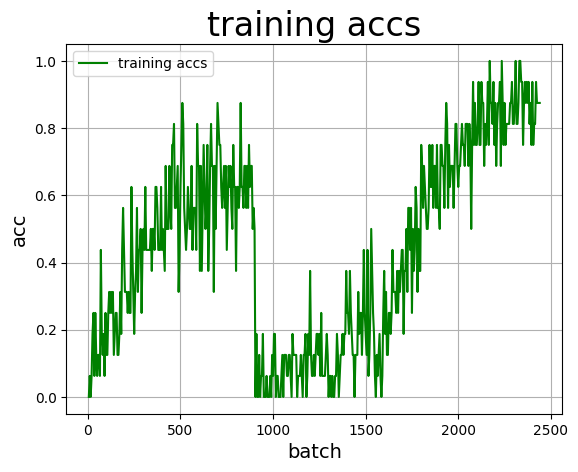

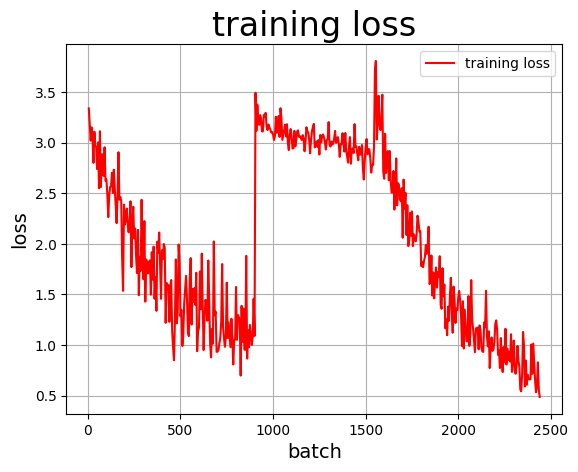

In [43]:
model=MyDNN() #模型实例化
model=paddle.vision.mobilenet_v1(pretrained=True,num_classes=25)
model.train() #训练模式
cross_entropy = paddle.nn.CrossEntropyLoss()
opt=paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters())

epochs_num=train_parameters['num_epochs'] #迭代次数
res={}
for pass_num in range(train_parameters['num_epochs']):
    if pass_num>0:break
    for batch_id,data in enumerate(train_loader()):
        if batch_id>0:break
        image = data[0]
        label = data[1]

        predict=model(image) #数据传入model

        loss=cross_entropy(predict,label)
        acc=paddle.metric.accuracy(predict,label)#计算精度
        res['out']=predict
        res['label']=label
        res['acc']=acc
        res['loss']=loss
        print("train_pass:{},batch_id:{},train_loss:{},train_acc:{}".format(pass_num,batch_id,loss.numpy(),acc.numpy()))
        if batch_id!=0 and batch_id%5==0:
            Batch = Batch+5 
            Batchs.append(Batch)
            all_train_loss.append(loss.numpy()[0])
            all_train_accs.append(acc.numpy()[0])
            
            print("train_pass:{},batch_id:{},train_loss:{},train_acc:{}".format(pass_num,batch_id,loss.numpy(),acc.numpy()))
        
        loss.backward()       
        opt.step()
        opt.clear_grad()   #opt.clear_grad()来重置梯度

paddle.save(model.state_dict(),'MyDNN')#保存模型

draw_train_acc(Batchs,all_train_accs)
draw_train_loss(Batchs,all_train_loss)

## 自己计算loss
paddle2.0计算的loss和paddle1.8计算的loss是不一样的。

In [44]:
for key in res:
    res[key]=res[key].numpy()
np.savez('自己计算loss.npz',**res)

In [49]:
_res=np.load('自己计算loss.npz')

In [50]:
res={}
for key in _res:
  res[key]=np.array(_res[key])

In [51]:
import numpy as np
_out=res['out']
_softmax=np.exp(_out)/np.sum(np.exp(_out),axis=1,keepdims=True)
print(_softmax.shape)
print(f'softmax:{_softmax[:3,:5]}')

(16, 25)
softmax:[[0.21718968 0.11824413 0.01958322 0.00533851 0.04664149]
 [0.0727118  0.03423106 0.02286324 0.011999   0.05388422]
 [0.02063552 0.01584999 0.01721427 0.02739398 0.01500913]]


In [52]:
print(f"argmax:{np.argmax(res['out'],axis=1)}")
print('label:',res['label'].T)
print(f"loss:{res['loss'].T}")
_log_res=np.log(_softmax)
print(f'_log_res:{_log_res[:3,:5]}')

argmax:[ 0 18 12  5 12  5  8  1  1 18 23 12 22 22 22 19]
label: [[ 3 13  8 23  4 21 11  7  1  5 16 11  5  9  9  7]]
loss:[4.060972]
_log_res:[[-1.5269842 -2.135004  -3.9330823 -5.232809  -3.065265 ]
 [-2.6212516 -3.3746219 -3.778225  -4.422932  -2.9209175]
 [-3.8807411 -4.1445866 -4.0620165 -3.597432  -4.1990967]]


In [53]:
_sum=0
for _id,_label in enumerate(res['label']):
    _sum+=-_log_res[_id][_label]/16.0   
print(f'loss:{_sum}')    

loss:[4.060972]


# 4、模型评估

In [ ]:
#模型评估
para_state_dict = paddle.load("MyDNN")
model = MyDNN()
model.set_state_dict(para_state_dict) #加载模型参数
model.eval() #验证模式

accs = []

for batch_id,data in enumerate(eval_loader()):#测试集
    image=data[0]
    label=data[1]     
    predict=model(image)       
    acc=paddle.metric.accuracy(predict,label)
    accs.append(acc.numpy()[0])
    avg_acc = np.mean(accs)
print("当前模型在验证集上的准确率为:",avg_acc)

当前模型在验证集上的准确率为: 0.44166666


# 5、模型预测

In [ ]:
import os
import zipfile

def unzip_infer_data(src_path,target_path):
    '''
    解压预测数据集
    '''
    if(not os.path.isdir(target_path)):     
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()


def load_image(img_path):
    '''
    预测图片预处理
    '''
    img = Image.open(img_path) 
    if img.mode != 'RGB': 
        img = img.convert('RGB') 
    img = img.resize((224, 224), Image.BILINEAR)
    img = np.array(img).astype('float32') 
    img = img.transpose((2, 0, 1))  # HWC to CHW 
    img = img/255                # 像素值归一化 
    return img


infer_src_path = '/home/aistudio/data/data55032/archive_test.zip'
infer_dst_path = '/home/aistudio/data/archive_test'
unzip_infer_data(infer_src_path,infer_dst_path)

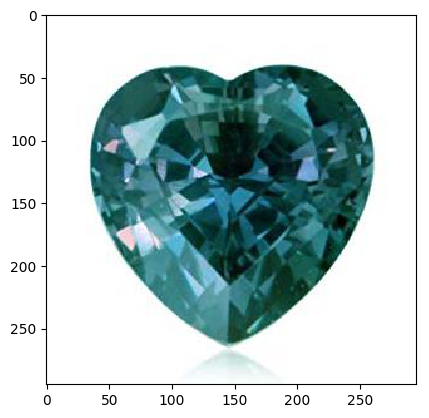

第1个样本,被预测为：Alexandrite,真实标签为：alexandrite
结束


In [ ]:
'''
模型预测
'''
para_state_dict = paddle.load("MyDNN")
model = MyDNN()
model.set_state_dict(para_state_dict) #加载模型参数
model.eval() #训练模式

#展示预测图片
infer_path='data/archive_test/alexandrite_3.jpg'
img = Image.open(infer_path)
plt.imshow(img)          #根据数组绘制图像
plt.show()               #显示图像

#对预测图片进行预处理
infer_imgs = []
infer_imgs.append(load_image(infer_path))
infer_imgs = np.array(infer_imgs)

label_dic = train_parameters['label_dict']

for i in range(len(infer_imgs)):
    data = infer_imgs[i]
    dy_x_data = np.array(data).astype('float32')
    dy_x_data=dy_x_data[np.newaxis,:, : ,:]
    img = paddle.to_tensor (dy_x_data)
    out = model(img)
    lab = np.argmax(out.numpy())  #argmax():返回最大数的索引

    print("第{}个样本,被预测为：{},真实标签为：{}".format(i+1,label_dic[str(lab)],infer_path.split('/')[-1].split("_")[0]))
        
print("结束")
